In [82]:
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import numpy as np
import pyfolio as pf
%matplotlib inline

<IPython.core.display.Javascript object>


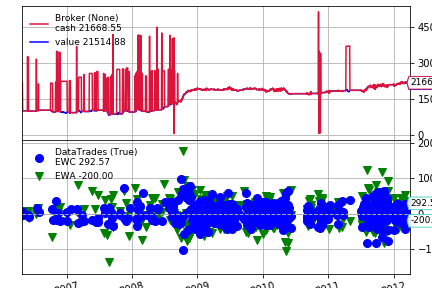

[[<Figure size 432x288 with 2 Axes>]]

In [101]:
class KalmanPair(bt.Strategy):
    params = (("printlog", False), ("quantity", 1000))

    def __init__(self):
        self.delta = 0.0001
        self.Vw = self.delta / (1 - self.delta) * np.eye(2)
        self.Ve = 0.001

        self.beta = np.zeros(2)
        self.P = np.zeros((2, 2))
        self.R = np.zeros((2, 2))

        self.position_type = None  # long or short
        self.quantity = self.params.quantity

    def next(self):

        x = np.asarray([self.data0[0], 1.0]).reshape((1, 2))
        y = self.data1[0]

        self.R = self.P + self.Vw  # state covariance prediction
        yhat = x.dot(self.beta)  # measurement prediction

        Q = x.dot(self.R).dot(x.T) + self.Ve  # measurement variance

        e = y - yhat  # measurement prediction error

        K = self.R.dot(x.T) / Q  # Kalman gain

        self.beta += K.flatten() * e  # State update
        self.P = self.R - K * x.dot(self.R)

        sqrt_Q = np.sqrt(Q)

        if self.position:
            if e > -sqrt_Q:
                self.close(self.data0)
                self.close(self.data1)
            if e < sqrt_Q:
                self.close(self.data0)
                self.close(self.data1)

        else:
            if e < -sqrt_Q:
                self.sell(data=self.data0, size=(self.quantity * self.beta[0]))
                self.buy(data=self.data1, size=self.quantity)

                self.position_type = "long"
            if e > sqrt_Q:
                self.buy(data=self.data0, size=(self.quantity * self.beta[0]))
                self.sell(data=self.data1, size=self.quantity)
                self.position_type = "short"




cerebro = bt.Cerebro()
cerebro.addstrategy(KalmanPair)

startdate = datetime(2006, 4, 26)
enddate = datetime(2012, 4, 9)

ewc = bt.feeds.YahooFinanceData(dataname="EWC", fromdate=startdate, todate=enddate, plot=False)
ewa = bt.feeds.YahooFinanceData(dataname="EWA", fromdate=startdate, todate=enddate, plot=False)

cerebro.adddata(ewc)
cerebro.adddata(ewa)
cerebro.broker.setcommission(commission=0.0)
cerebro.broker.setcash(10000.0)
cerebro.broker.set_coc(True)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
cerebro.plot()

Start date,2006-04-26
End date,2012-04-05
Total months,71
,Backtest
Annual return,13.7%
Cumulative returns,115.1%
Annual volatility,18.1%
Sharpe ratio,0.80
Calmar ratio,0.64
Stability,0.77
Max drawdown,-21.6%


<IPython.core.display.Javascript object>


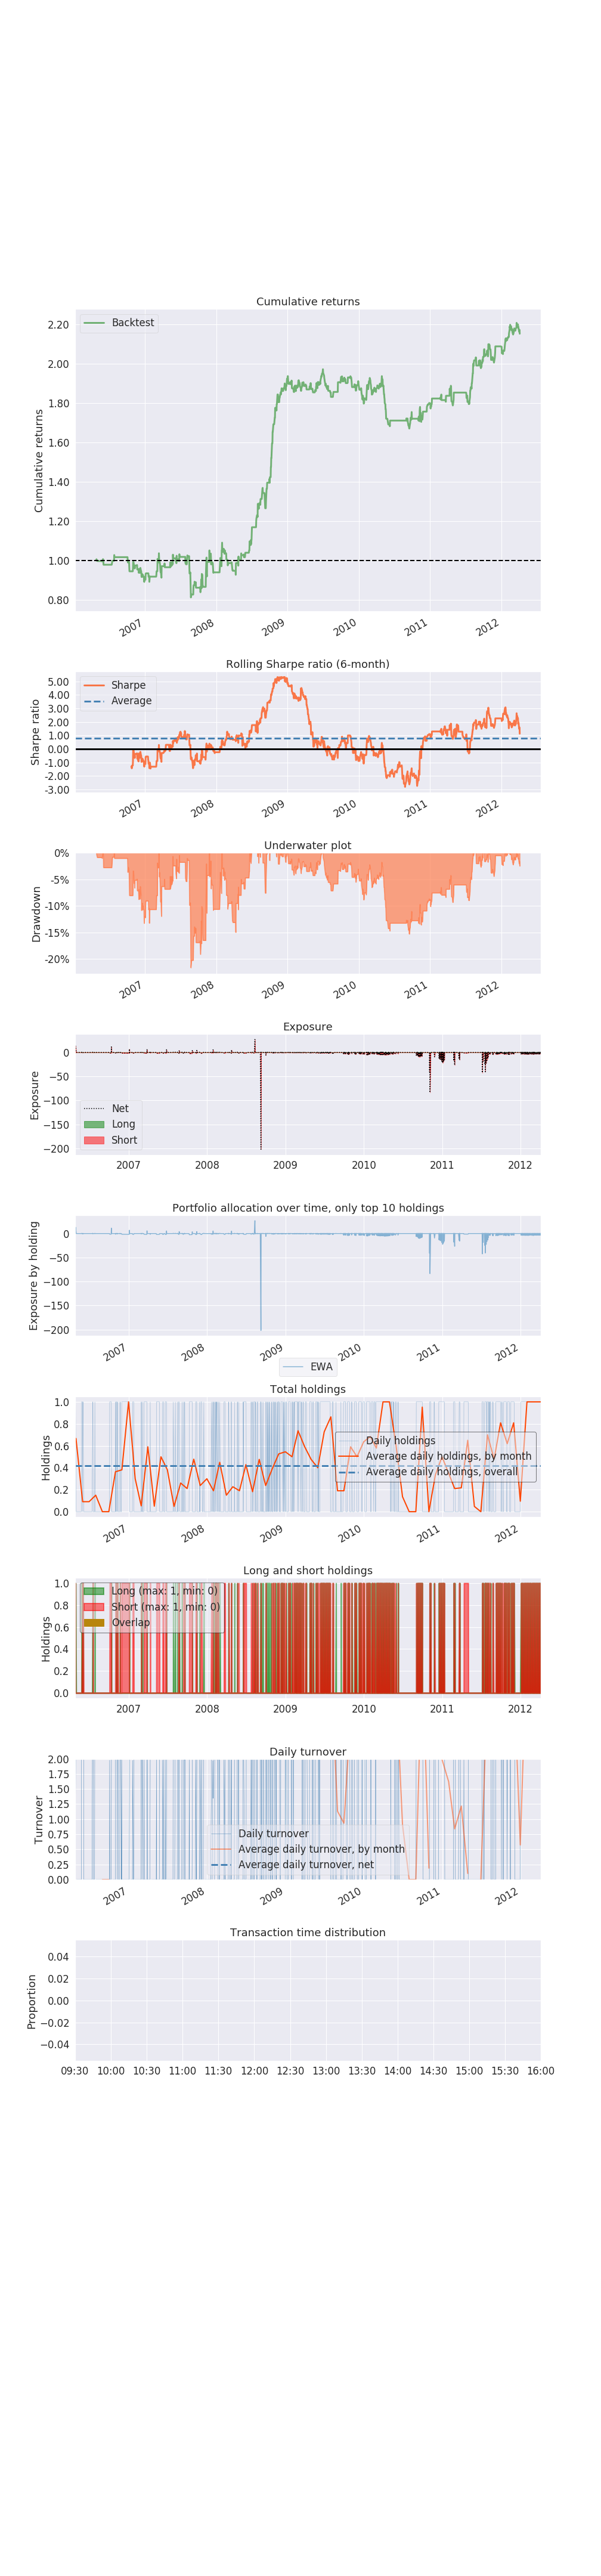

In [89]:

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_simple_tear_sheet(returns, positions=positions, transactions=transactions)